# RECOVAR visualization and analysis (copied from cryoDRGN's)

This jupyter notebook provides a template for analyzing results, including:
* latent space visualization with PCA/UMAP
* clustering
* interactive visualization of the latent space, imaging, and pose parameters
* interactive selection of particle images from the latent space
* interactive generation of volumes from the latent space

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.



In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
# from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Load results

In [3]:
# Specify the result dir
WORKDIR = '..' 
# recovar_result_dir = '/scratch/gpfs/mg6942/cryodrgn_empiar/empiar10076/inputs/test/'
# # recovar_result_dir = '/home/mg6942/mytigress/uniform/recovar_from_halfmapstest/'
# recovar_result_dir = '/home/mg6942/mytigress/challenge_1/cryoem_heterogeneity_challenge_2023_first_dataset/test/'


In [6]:
# Load z
from recovar import output
from recovar import dataset
results = output.load_results_new(recovar_result_dir)
cryos = dataset.load_dataset_from_args(results['input_args'], lazy = True)
z_dim_used = list(results['zs'].keys())[-1]
print("available zdim:", list(results['zs'].keys()), "using:", z_dim_used)
z = results['zs'][z_dim_used]

(INFO) (dataset.py) (18-Oct-23 17:19:14) Loading halfset from file
(INFO) (ctf.py) (18-Oct-23 17:19:14) Image size (pix)  : 128
(INFO) (ctf.py) (18-Oct-23 17:19:14) A/pix             : 3.755499839782715
(INFO) (ctf.py) (18-Oct-23 17:19:14) DefocusU (A)      : 10454.572265625
(INFO) (ctf.py) (18-Oct-23 17:19:14) DefocusV (A)      : 10241.7001953125
(INFO) (ctf.py) (18-Oct-23 17:19:14) Dfang (deg)       : 29.741111755371094
(INFO) (ctf.py) (18-Oct-23 17:19:14) voltage (kV)      : 300.0
(INFO) (ctf.py) (18-Oct-23 17:19:14) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (18-Oct-23 17:19:14) w                 : 0.10000000149011612
(INFO) (ctf.py) (18-Oct-23 17:19:14) Phase shift (deg) : 0.0
(INFO) (ctf.py) (18-Oct-23 17:19:15) Image size (pix)  : 128
(INFO) (ctf.py) (18-Oct-23 17:19:15) A/pix             : 3.755499839782715
(INFO) (ctf.py) (18-Oct-23 17:19:15) DefocusU (A)      : 10454.572265625
(INFO) (ctf.py) (18-Oct-23 17:19:15) DefocusV (A)      : 10241.7001953125
(INFO) (ctf.py)

In [7]:
# Load UMAP
umap = utils.load_pkl(f'{recovar_result_dir}output/umap_embedding.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

/home/mg6942/miniconda3/envs/recovar/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



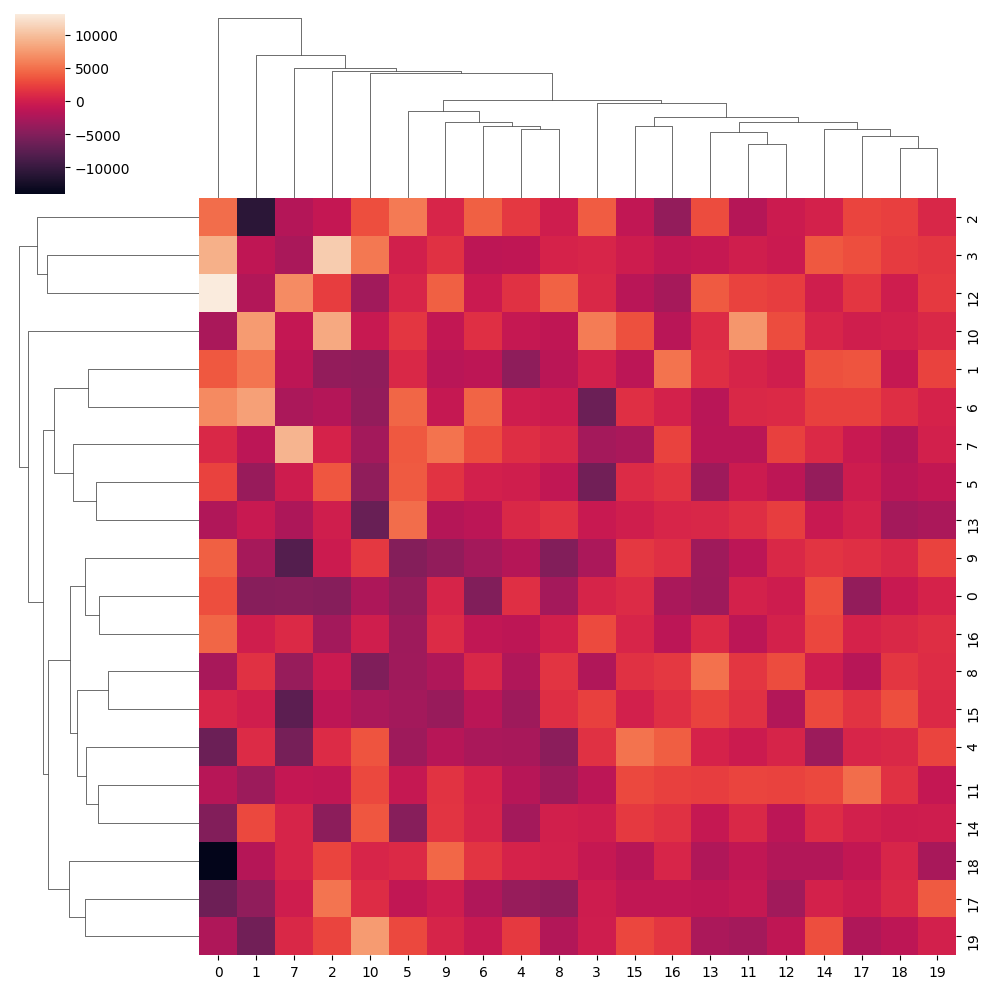

In [8]:
# Load kmeans
# K = 40
# kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
# kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
# Or re-run kmeans with the desired number of classes
kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# # Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Load dataset

In [9]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])

(INFO) (ctf.py) (18-Oct-23 17:19:16) Image size (pix)  : 19931
(INFO) (ctf.py) (18-Oct-23 17:19:16) A/pix             : 19402.20703125
(INFO) (ctf.py) (18-Oct-23 17:19:16) DefocusU (A)      : 30.458311080932617
(INFO) (ctf.py) (18-Oct-23 17:19:16) DefocusV (A)      : 300.0
(INFO) (ctf.py) (18-Oct-23 17:19:16) Dfang (deg)       : 2.700000047683716
(INFO) (ctf.py) (18-Oct-23 17:19:16) voltage (kV)      : 0.10000000149011612
(INFO) (ctf.py) (18-Oct-23 17:19:16) cs (mm)           : 0.0
(INFO) (ctf.py) (18-Oct-23 17:19:16) w                 : 0.0
(INFO) (ctf.py) (18-Oct-23 17:19:16) Phase shift (deg) : 1.0


### Learning curve

### PCA

In [12]:
pc, pca = analysis.run_pca(z)

(INFO) (analysis.py) (18-Oct-23 17:20:42) Explained variance ratio:
(INFO) (analysis.py) (18-Oct-23 17:20:42) [0.11311916 0.08968401 0.08158467 0.07656368 0.06745955 0.0573425
 0.05005661 0.04485031 0.043055   0.04080243 0.03999175 0.03843322
 0.03589318 0.03512524 0.03335296 0.0326089  0.03216272 0.0308479
 0.02940234 0.027664  ]


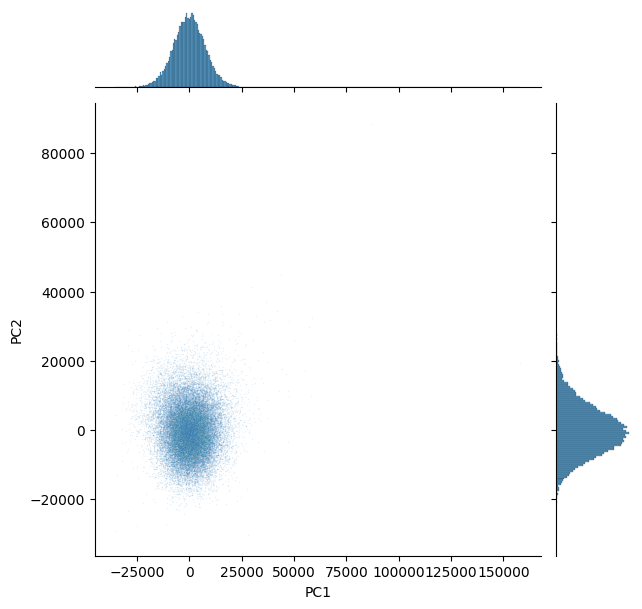

In [13]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

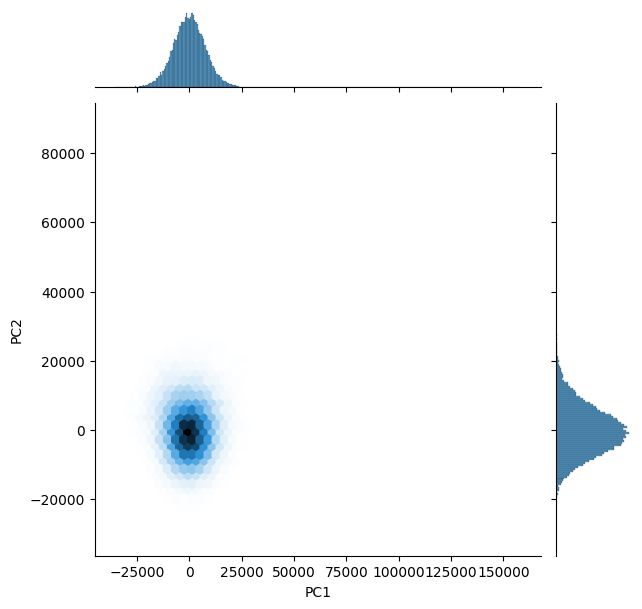

In [14]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

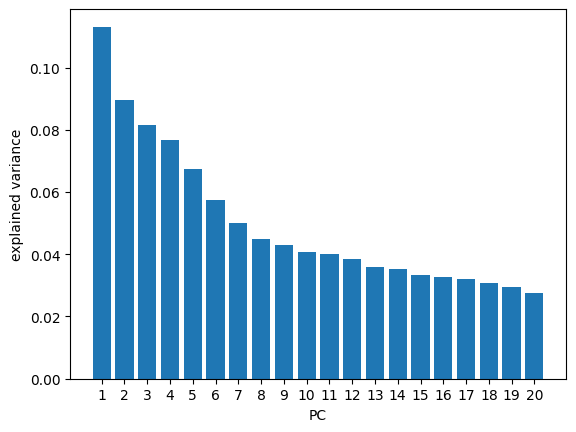

In [15]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### View pose distribution

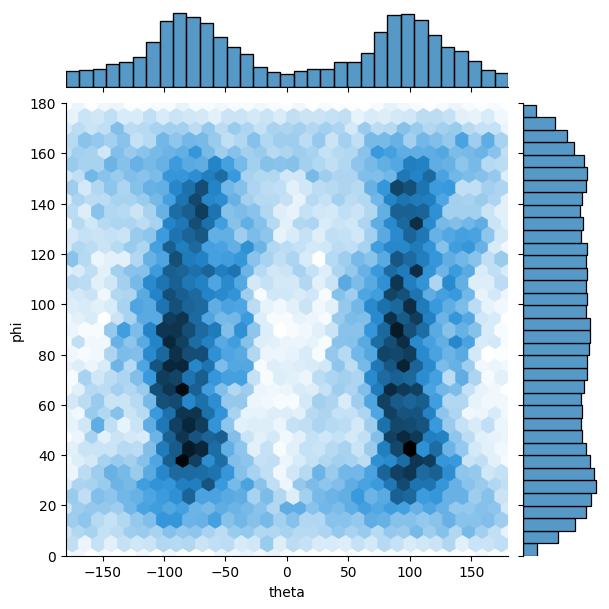

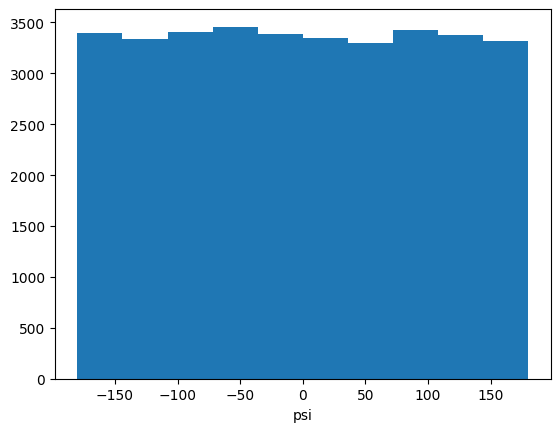

In [16]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

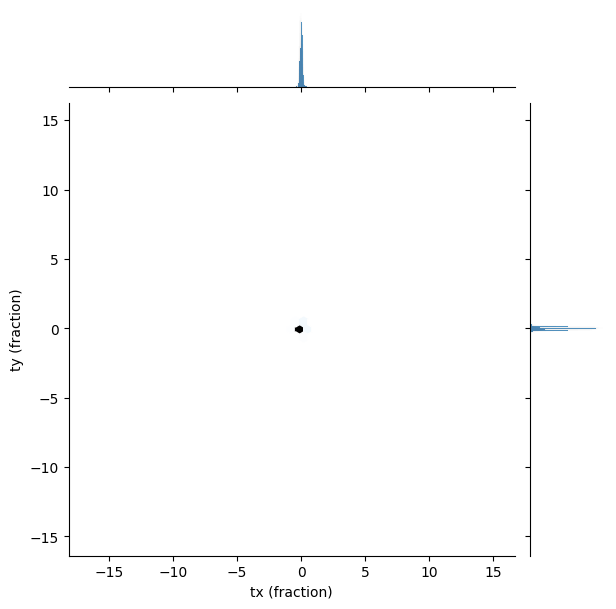

In [17]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### View UMAP

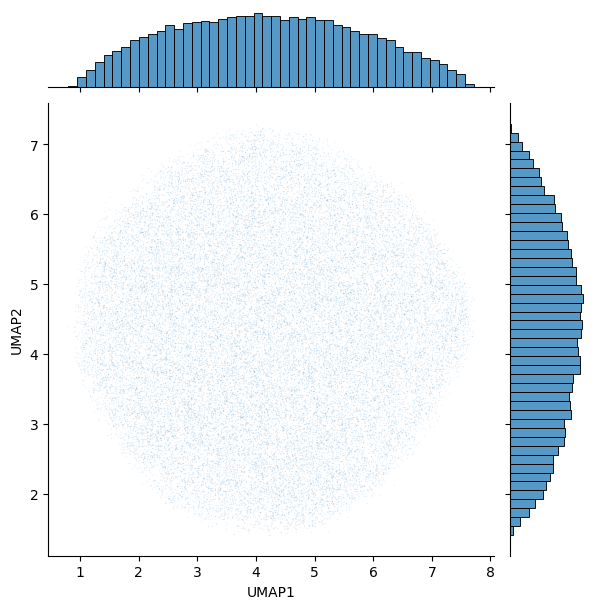

In [18]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

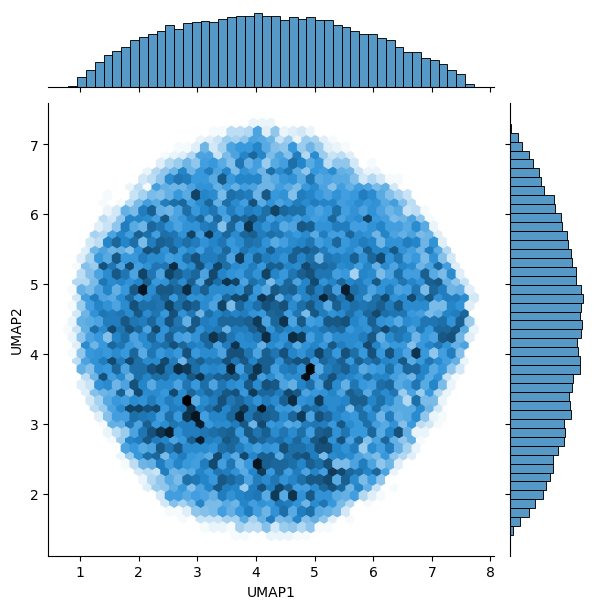

In [19]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

### View K-means clusters

Text(0, 0.5, 'PC2')

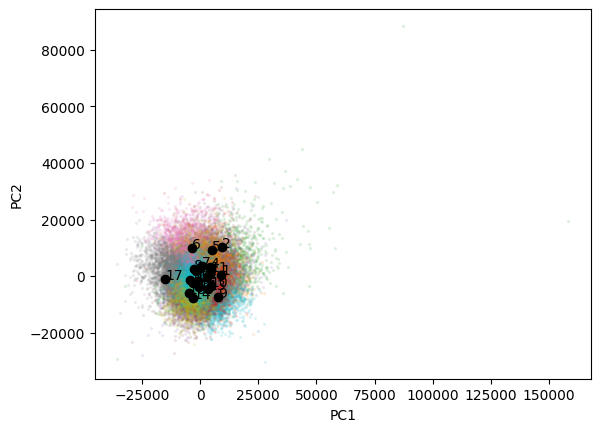

In [20]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

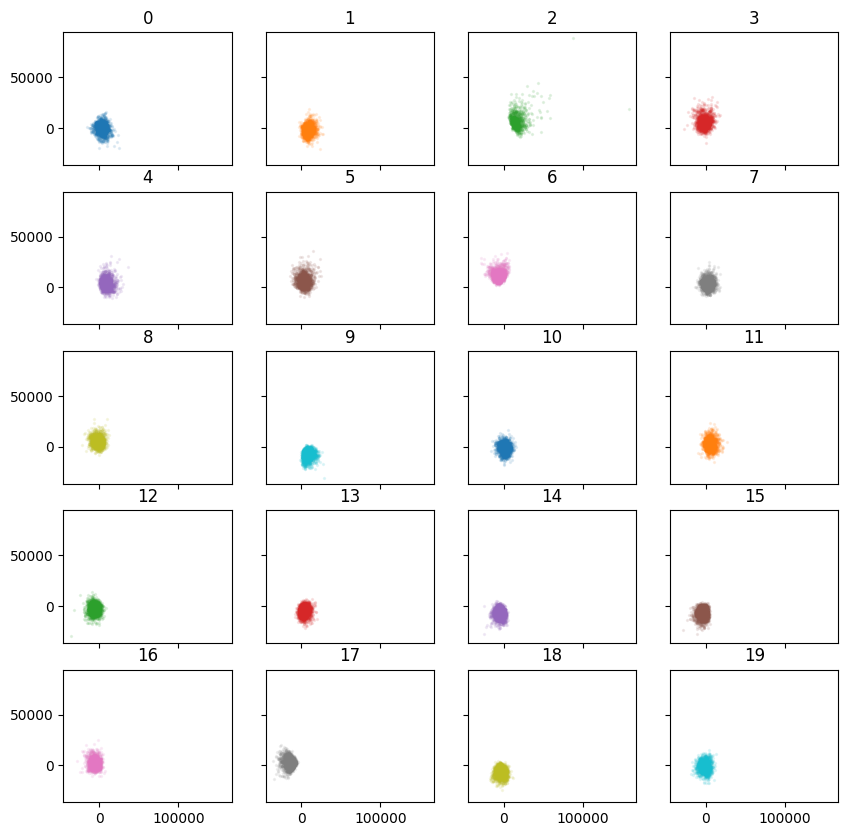

In [21]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

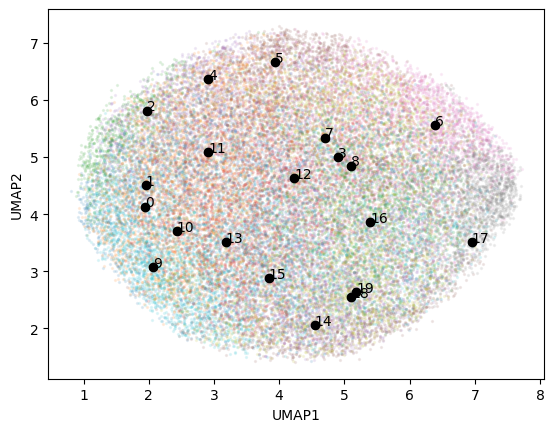

In [22]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

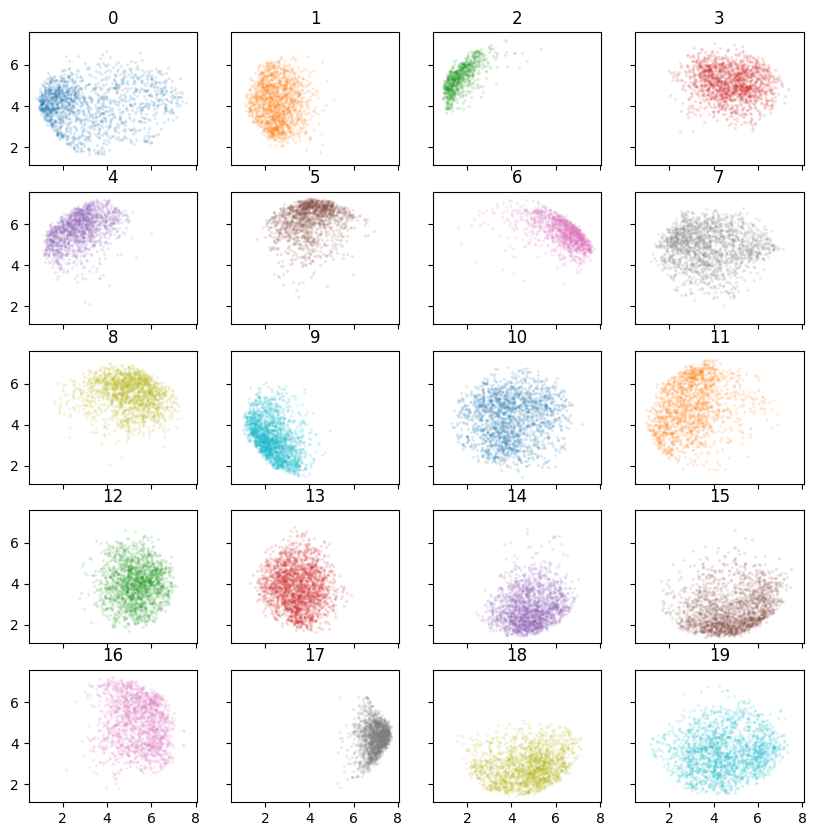

In [23]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

### Load into pandas dataframe

In [24]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8])
df.head()

UMAP1     UMAP2          PC1          PC2          PC3           PC4  \
0  2.833485  4.893717  7260.564941  5473.931641  2077.614014  -5278.347656   
1  2.610781  4.553557  7062.444824 -2772.448242  3329.548584   1909.697021   
2  3.346297  4.386014  2471.636719 -3587.637207 -2289.036865  -5843.026367   
3  3.190392  4.196141  3913.497070 -2319.809814 -4846.138672   5936.687988   
4  5.394395  2.668319 -7181.272461 -9320.082031 -3696.277344  10160.886719   

           PC5          PC6          PC7           PC8  ...          z15  \
0  7570.970215  3743.494629  1672.120239   3102.759521  ...  3606.868164   
1  -464.103790 -2621.594971 -7217.647461   7208.991699  ...  2001.754517   
2  1321.305786  4431.411621  6046.468262  17145.472656  ...   665.897034   
3  2512.455322  6136.834961  3927.300049   3748.198242  ... -1302.882690   
4  5598.393555  5302.342773 -2581.324707  -4253.760742  ... -4060.933594   

           z16           z17          z18           z19        df1    df2  \
0  1225.159546  -2495.501709 -1246.969482 -10533.522461  30.458311  300.0   
1 -2601.900635  -3138.063232  4446.469727   4654.627441  36.977386  300.0   
2  1595.200684  10411.932617    34.521568  -2265.259277  35.462635  300.0   
3 -2879.431152   4543.252441 -2890.051270   4320.391113  32.985725  300.0   
4 -3257.931396  -2583.511963  1657.979614  -1444.734619  34.370239  300.0   

   dfang  phase  index  
0    2.7    1.0      0  
1    2.7    1.0      1  
2    2.7    1.0      2  
3    2.7    1.0      3  
4    2.7    1.0      4  

[5 rows x 53 columns]

In [25]:
# Annotated points correspond to kmeans cluster centers
widget, fig = analysis.ipy_plot_interactive_annotate(df,centers_ind)
VBox((widget,fig))

# Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, use the next cell to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [26]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [27]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = np.array(sorted(set(np.arange(len(df))) - set(ind_selected)))

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    0     1     2 ... 33739 33740 33741]
Number of selected points:
33742
Number of unselected points:
0


### Visualize selected subset

Text(0, 0.5, 'PC2 (0.09)')

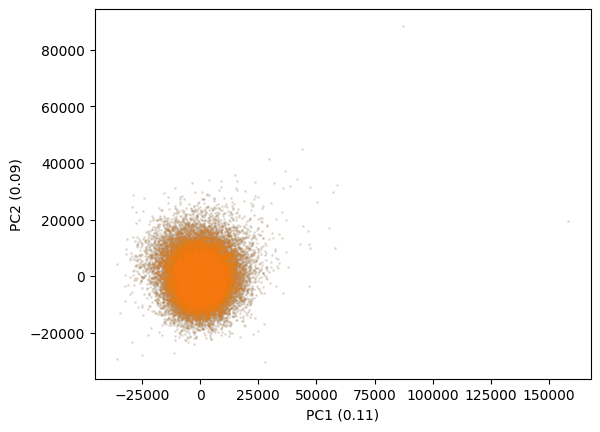

In [28]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

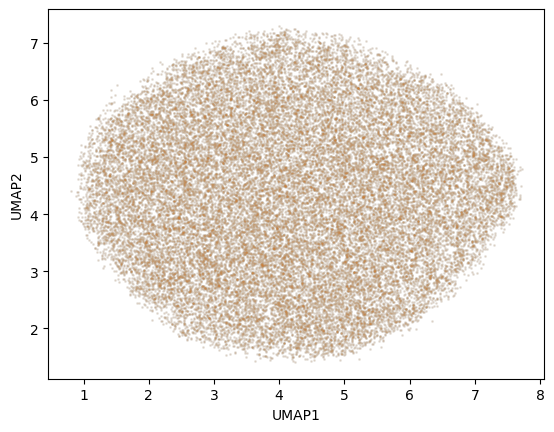

In [29]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [30]:
# Subset of dataframe
df_sub = df.loc[ind_selected]
df_sub_not = df.loc[ind_selected_not]

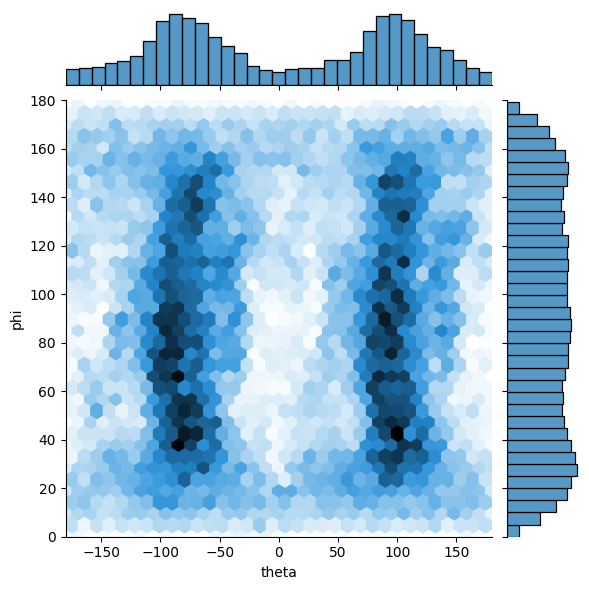

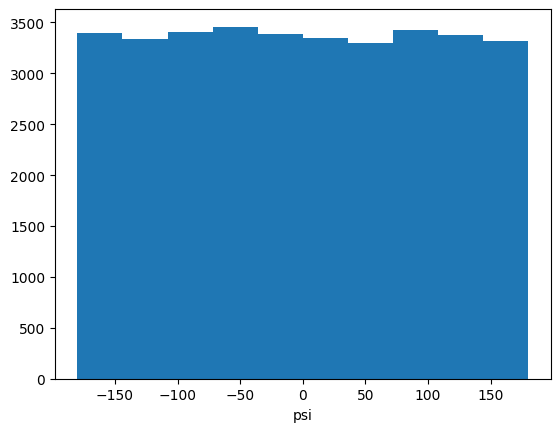

In [31]:
# View pose distribution
analysis.plot_euler(df_sub.theta, df_sub.phi, df_sub.psi)

In [32]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df_sub)
VBox((widget,fig,ind_table))

In [33]:
# import plotly
# import numpy as np
# X = np.random.randn(10,3)
# from recovar import plot_utils
# plot_utils.plotly_scatter([X])
# # import plotly.express as px
# # fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
# # fig.write_html('first_figure.html', auto_open=True)


### Save the index selection

The indices for the selected particles may be saved for use in downstream processing in cryoDRGN or with other tools. Within cryoDRGN, selections are saved as an index array in `.pkl` file format. Then, the selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images. 

Tools are provided in the `utils` subdirectory of the cryoDRGN repo to help convert the index selection to `.star` file format.

**NOTE:** If there are multiple rounds of index filtering performed on the same particle stack (i.e. your results come from a training run that already uses an --ind subselection), the index selection must be converted into the correct indices into the original dataset.

In [34]:
#SAVE_PATH = f'{WORKDIR}/ind_selected.pkl' # RENAME ME

## IMPORTANT: convert index selection to original particles indices if current results have already been filtered

#if ind_orig is not None:
#    ind_selected_orig = analysis.convert_original_indices(ind_selected, N_orig, ind_orig)
#    utils.save_pkl(ind_selected_orig, SAVE_PATH)

#else:
#    utils.save_pkl(ind_selected, SAVE_PATH)

# View particles

View images at selected points in latent space

In [35]:
particle_ind = ind_selected # or set to custom selection

In [36]:
# choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[13464 10320 24119  4966 20569 17724 30223 17130  9396]


In [37]:
particle_ind

array([    0,     1,     2, ..., 33739, 33740, 33741])

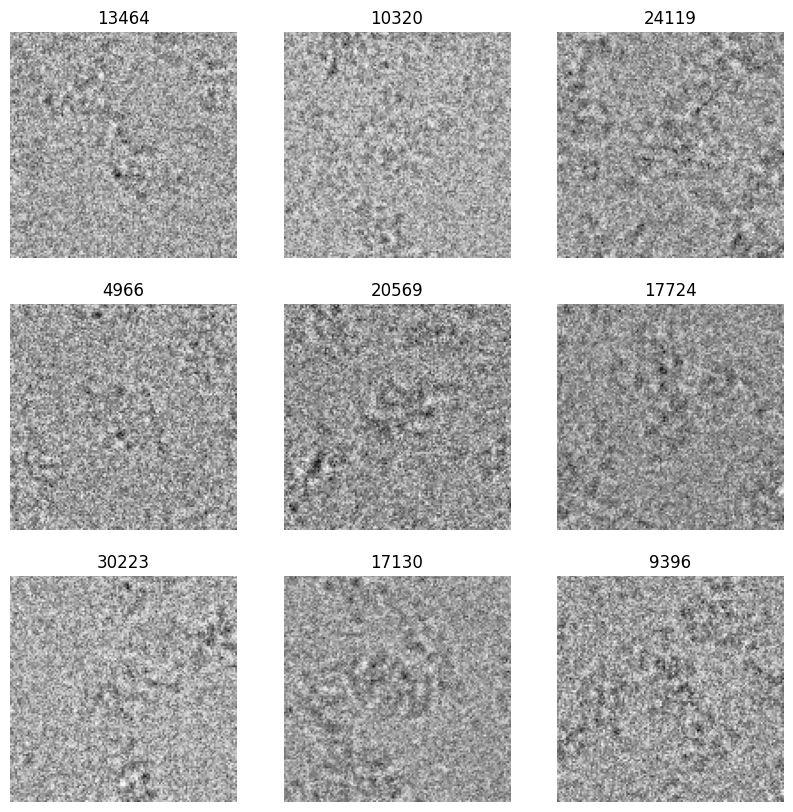

In [38]:
p = [cryos[0].get_image_real(ii % cryos[0].n_images) for ii in ind_subset9]
analysis.plot_projections(p, ind_subset9)
widget, fig = analysis.ipy_plot_interactive_annotate(df, ind_subset9, opacity=.1)
VBox((widget,fig))

# Generate volumes

Generate volumes at selected points in latent space

In [39]:
vol_ind = [] # ADD INDICES HERE
print(vol_ind)

[]


In [40]:
widget, fig = analysis.ipy_plot_interactive_annotate(df, vol_ind, opacity=.1)
VBox((widget,fig))

In [92]:
def get_outdir():
    '''Helper function to get a clean directory to save volumes'''
    for i in range(100000):
        outdir = f'reconstruct_{i:06d}'
        if os.path.exists(outdir): continue
        else: break
    return outdir

def generate_volumes(zvalues, outdir, **kwargs):
    '''Helper function to call cryodrgn eval_vol and generate new volumes'''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(f'{WORKDIR}/weights.{EPOCH}.pkl',
                         f'{WORKDIR}/config.pkl',
                         f'{outdir}/zfile.txt',
                         f'{outdir}', **kwargs)
    return FileLinks(f'{outdir}/')

In [94]:
# # Get a unique output directory, or define your own
# outdir = get_outdir()
# print(os.path.abspath(outdir))

In [95]:
# Modify any defaults for volume generation -- see `cryodrgn eval_vol -h` for details 
Apix = 1 # Set to volume pixel size
flip = False # Hand flip?
invert = False # Invert contrast?
downsample = None # Set to smaller box size if desired
cuda = None # specify cuda device

generate_volumes(z[vol_ind], outdir, Apix=cryos[0].voxel_size, flip=flip, downsample=downsample, cuda=cuda, invert=invert)

NameError: name 'EPOCH' is not defined